# 0. Introduction

data: synchronized_brainwave_dataset.csv

row of data:

\#: the index of eath row

id: participant_id, integer value in the range of 1 to 30, means 30 participants.


indra_time: time of all stimulus events

browser_latency

reading_time

attention_esense: The Attention Meter algorithm indicates the intensity of mental “focus” or “attention.” The value ranges from 0 to 100. The attention level increases when a user focuses on a single thought or an external object, and decreases when distracted.(https://neurosky.com/biosensors/eeg-sensor/algorithms/)

meditation_esense: The Meditation Meter algorithm indicates the level of mental “calmness” or “relaxation.” The value ranges from 0 to 100, and increases when users relax the mind and decreases when they are uneasy or stressed.(https://neurosky.com/biosensors/eeg-sensor/algorithms/)

eeg_power: Tuple represents the magnitude of 8 commonly-recognized types of EEG frequency bands -- delta (0.5 - 2.75Hz), theta (3.5 - 6.75Hz), low-alpha (7.5 - 9.25Hz), high-alpha (10 - 11.75Hz), low-beta (13 - 16.75Hz), high-beta (18 - 29.75Hz), low-gamma (31 - 39.75Hz), and mid-gamma (41 - 49.75Hz). These values have no units and are only meaningful for comparison to the values for the other frequency bands within a sample.(https://courses.ischool.berkeley.edu/i290-shda/f14/ColorCountingChallenge/)

raw_values: Tuple containing raw sample values acquired by the sensor

signal_quality: A signal quality of 0 is optimal. Values over 128 indicate that the headset was placed incorrectly.

createdAt: when data were created

updatedAt: when data were updated

label: Indicate what the participant is doing.

The device only has one electrode and it is placed roughly at fp1, according to the dataset creator.(https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset/discussion/284896)


# 1. Baseline

In this baseline, we want to classify labels math and relax using column raw_data. We have 934 rows of data for relax and 936 rows for math. Each row has a raw_data column which is a 512 length list, this 512 length list acts as feature in our model.


In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import tsgm
from tsgm.models.architectures.zoo import zoo  
from tensorflow.keras.utils import to_categorical
import ast
%matplotlib inline

In [35]:
X, y = tsgm.utils.get_synchronized_brainwave_dataset()
print('feature shape in total data:',X.shape)
print('label shape in total data:',y.shape)

INFO:utils:File exist


feature shape in total data: (30013, 12)
label shape in total data: (30013,)


In [36]:
df = pd.read_csv("../data/synchronized_brainwave_dataset.csv")

In [37]:
# we want to classify label 'relax' and 'math'
relax = df[df.label == 'relax']
math = df[(df.label == 'math1') |
          (df.label == 'math2') |
          (df.label == 'math3') |
          (df.label == 'math4') |
          (df.label == 'math5') |
          (df.label == 'math6') |
          (df.label == 'math7') |
          (df.label == 'math8') |
          (df.label == 'math9') |
          (df.label == 'math10') |
          (df.label == 'math11') |
          (df.label == 'math12') ]

print('length of relax data:',len(relax))
print('length of math data',len(math))

length of relax data: 934
length of math data 936


In [38]:
# relax

In [39]:
relax_math = pd.concat([relax, math], axis=0)

In [40]:
relax_math['raw_values'] = relax_math['raw_values'].apply(ast.literal_eval)

In [41]:
# A signal values over 128 indicate that the headset was placed incorrectly.
relax_math = relax_math[relax_math['signal_quality'] < 128]

relax_math['label'] = relax_math['label'].str.replace(r'^math.*$', 'math', regex=True)

relax_math['raw_values'] = relax_math['raw_values'].apply(lambda x: np.array(x, dtype=float))

# Ensure all arrays have the same length
max_len = max(relax_math['raw_values'].apply(len))
relax_math['raw_values'] = relax_math['raw_values'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x)

# print(relax_math['label'][:10])

In [42]:
# convert label, relax=1, math=0
label_encoder = LabelEncoder()
relax_math['label'] = label_encoder.fit_transform(relax_math['label'])

features_matrix = np.stack(relax_math['raw_values'].values)

In [43]:
# we choose column 'raw_values' as our feature for label
X = features_matrix
y = relax_math['label']

In [44]:
# print('data shape:', relax_math.shape)
print('feature shape:', X.shape)
print('label shape:', y.shape)
# print(X.head())

feature shape: (1870, 512)
label shape: (1870,)


In [45]:
# relax_math['label']

In [46]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print(X_train.shape)
print(y_train.shape)

(1496, 512)
(1496,)


## 1.0 Data shape

In [48]:
seq_len = 8  # Number of timesteps per sequence
feat_dim = 64  # Number of features per timestep
output_dim = 2  # Number of output classes

X_train_ts = X_train.reshape(-1, seq_len, feat_dim) 
X_val_ts = X_val.reshape(-1, seq_len, feat_dim)



## 1.1 Time series model

In [49]:
model_ts_architecture = zoo['clf_cn'](seq_len, feat_dim, output_dim)
model_ts = model_ts_architecture.model

model_ts.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)


In [50]:
# print(X_train_ts.shape)
# print(y_train.shape)
# print(y_train[:10])

In [51]:
# Model training
history_ts = model_ts.fit(
    X_train_ts, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [52]:
val_loss_ts, val_acc_ts = model_ts.evaluate(X_val_ts, y_val)
print('val loss in ts model:', val_loss_ts)
print("val accuracy in ts model:", val_acc_ts)

12/12 [==============================] - 0s 582us/step - loss: 1.9804 - accuracy: 0.5802
val loss in ts model: 1.9804065227508545
val accuracy in ts model: 0.5802139043807983


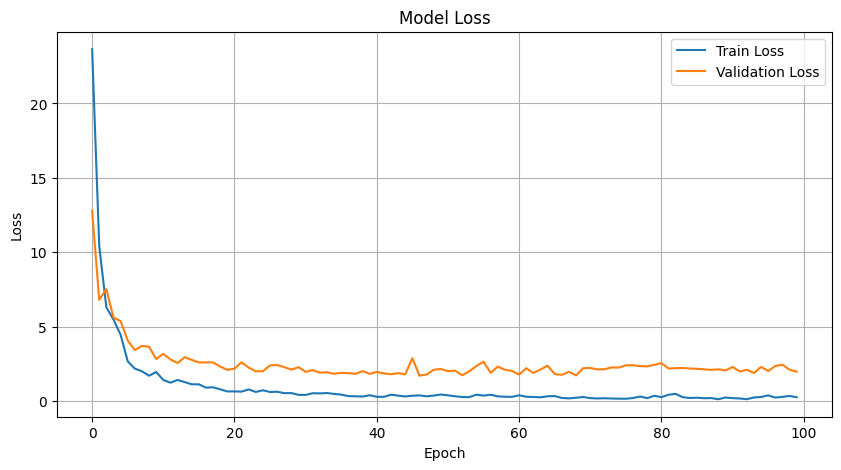

In [53]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_ts.history['loss'], label='Train Loss')
plt.plot(history_ts.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

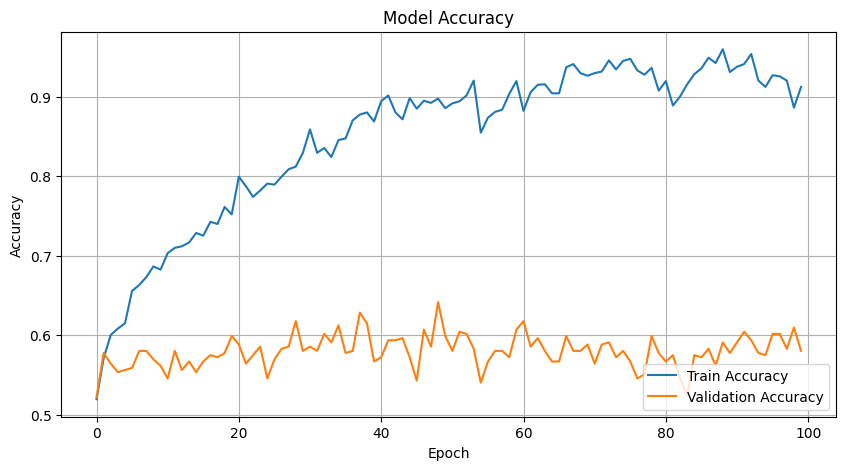

In [54]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_ts.history['accuracy'], label='Train Accuracy')
plt.plot(history_ts.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 1.2 Sequential model

In [55]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(max_len,)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              # loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [56]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0
)

In [57]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print('val loss in normal model:', val_loss)
print("val accuracy in normal model:", val_acc)

12/12 [==============================] - 0s 482us/step - loss: 1.4272 - accuracy: 0.4813
val loss in normal model: 1.427160382270813
val accuracy in normal model: 0.48128342628479004


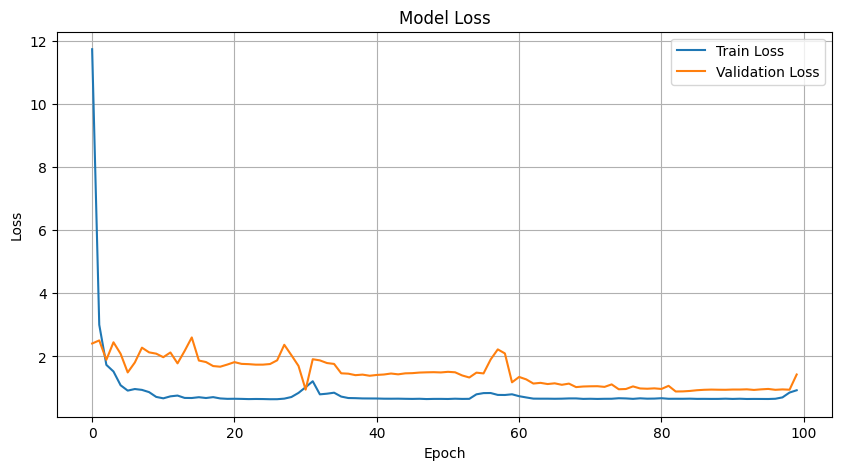

In [58]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

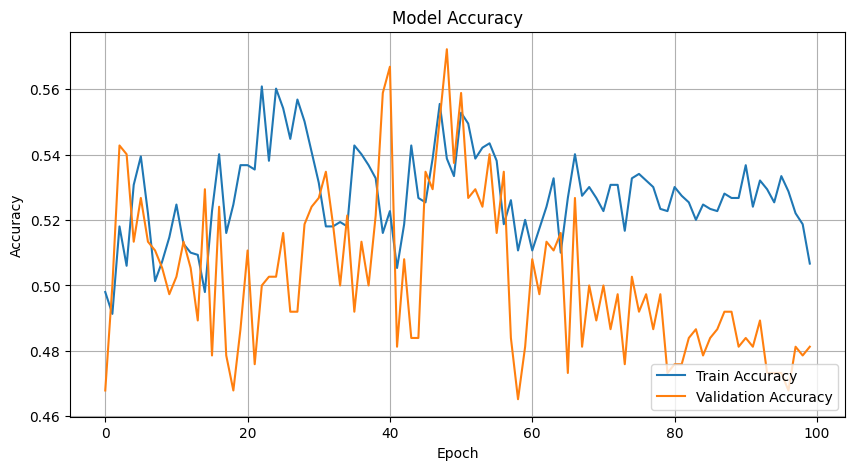

In [59]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 1.3 LSTM model

In [153]:
seq_len = 8
feat_dim = 64  
num_heads = 4 
ff_dim = 64 
n_blocks = 2 
dropout_rate = 0.1  
output_dim = 2

X_train_reshaped = X_train.reshape(-1, seq_len, feat_dim)

model_transformer = tsgm.models.architectures.zoo['clf_transformer'](
    seq_len, feat_dim, num_heads, ff_dim, n_blocks, dropout_rate, output_dim
).model


In [154]:
model_transformer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [155]:
# Train the model
history = model_transformer.fit(X_train_reshaped, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
38/38 [==============================] - 1s 9ms/step - loss: 0.7564 - accuracy: 0.5242 - val_loss: 0.7618 - val_accuracy: 0.4867
Epoch 2/10
38/38 [==============================] - 0s 6ms/step - loss: 0.7231 - accuracy: 0.5385 - val_loss: 0.7244 - val_accuracy: 0.4967
Epoch 3/10
38/38 [==============================] - 0s 7ms/step - loss: 0.7164 - accuracy: 0.5209 - val_loss: 0.7380 - val_accuracy: 0.4933
Epoch 4/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6860 - accuracy: 0.5778 - val_loss: 0.7066 - val_accuracy: 0.5067
Epoch 5/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6732 - accuracy: 0.5853 - val_loss: 0.7118 - val_accuracy: 0.5167
Epoch 6/10
38/38 [==============================] - 0s 8ms/step - loss: 0.6643 - accuracy: 0.6045 - val_loss: 0.7310 - val_accuracy: 0.5500
Epoch 7/10
38/38 [==============================] - 0s 9ms/step - loss: 0.6494 - accuracy: 0.6438 - val_loss: 0.7399 - val_accuracy: 0.5300
Epoch 8/10
38/38 [==

In [157]:
print(history.history.keys())

print("Training and validation loss and accuracy per epoch:")
for i in range(len(history.history['loss'])):
    print(f"Epoch {i+1}:")
    print(f"  Training Loss:     {history.history['loss'][i]}")
    print(f"  Validation Loss:   {history.history['val_loss'][i]}")
    print(f"  Training Accuracy: {history.history['accuracy'][i]}")
    print(f"  Validation Accuracy: {history.history['val_accuracy'][i]}")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training and validation loss and accuracy per epoch:
Epoch 1:
  Training Loss:     0.7564222812652588
  Validation Loss:   0.7617508172988892
  Training Accuracy: 0.5242474675178528
  Validation Accuracy: 0.4866666793823242
Epoch 2:
  Training Loss:     0.7230923771858215
  Validation Loss:   0.7244166731834412
  Training Accuracy: 0.5384615659713745
  Validation Accuracy: 0.49666666984558105
Epoch 3:
  Training Loss:     0.7164076566696167
  Validation Loss:   0.7380483746528625
  Training Accuracy: 0.5209029912948608
  Validation Accuracy: 0.4933333396911621
Epoch 4:
  Training Loss:     0.6860132217407227
  Validation Loss:   0.7065643072128296
  Training Accuracy: 0.5777592062950134
  Validation Accuracy: 0.5066666603088379
Epoch 5:
  Training Loss:     0.6732048392295837
  Validation Loss:   0.7117672562599182
  Training Accuracy: 0.5852842926979065
  Validation Accuracy: 0.5166666507720947
Epoch 6:
  Training Loss:     0

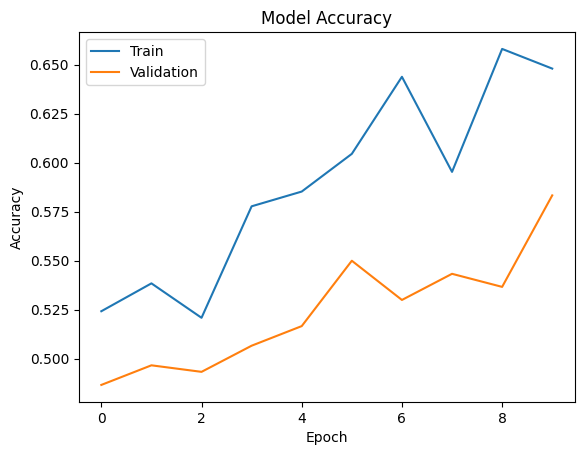

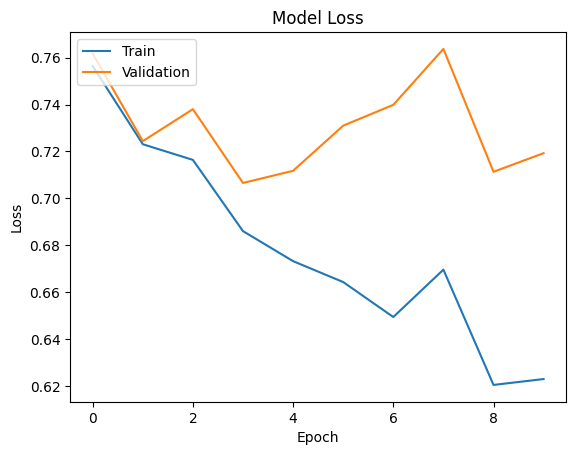

In [158]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [156]:
val_loss, val_acc = model_transformer.evaluate(X_val, y_val)
print('val loss in normal model:', val_loss)
print("val accuracy in normal model:", val_acc)

ValueError: in user code:

    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'layer_normalization_36' (type LayerNormalization).
    
    Cannot take the length of shape with unknown rank.
    
    Call arguments received by layer 'layer_normalization_36' (type LayerNormalization):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)


# 2. Augmentations

augment X_train_ts and y_train using GAN

## 2.0 Parameters and data perpare

In [62]:
seq_len = 8
feat_dim = 64
batch_size = 128
latent_dim = 64
output_dim = 2

# generator_in_channels = latent_dim + output_dim
# discriminator_in_channels = feature_dim + output_dim

In [63]:
print(X_train_ts.shape)
print(type(X_train_ts))

(1496, 8, 64)
<class 'numpy.ndarray'>


In [64]:
from sklearn.preprocessing import MinMaxScaler
# todo: do we need to scale X??
X_min = X_train_ts.min(axis=(0, 1), keepdims=True)
X_max = X_train_ts.max(axis=(0, 1), keepdims=True)

X_train_ts_scaled = 2 * ((X_train_ts - X_min) / (X_max - X_min)) - 1

# scaler = MinMaxScaler(feature_range=(-1, 1))
# X_train_ts_scaler = np.stack(X_train_ts.apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten()))
X_train_ts_scaled_32 = X_train_ts_scaled.astype(np.float32)
y_train_32 = y_train.astype(np.float32)
y_train_onehot_32 = to_categorical(y_train, num_classes=output_dim)

In [65]:
print(X_train_ts_scaled_32.shape)
print(y_train_onehot_32.shape)

(1496, 8, 64)
(1496, 2)


In [66]:
# adjust its shape to series
# X_np = X.to_numpy() 
# X_ts = X_np.reshape(-1, seq_len, feat_dim) 
# X_ts.shape

# scaler = MinMaxScaler(feature_range=(-1, 1))
# X = np.stack(relax_math['raw_values'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten()))
# y = keras.utils.to_categorical(relax_math['label'], num_classes=2)

# scaler = tsgm.utils.TSFeatureWiseScaler((-1, 1))
# X_train = scaler.fit_transform(X_train_ts_32)


In [67]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_ts_scaled_32, y_train_onehot_32))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

## 2.1 cgan_base_c4_l1

In [68]:
architecture = tsgm.models.architectures.zoo["cgan_base_c4_l1"](
    seq_len=seq_len, feat_dim=feat_dim,
    latent_dim=latent_dim, output_dim=output_dim)
discriminator, generator = architecture.discriminator, architecture.generator

In [69]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.5),
    g_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=False, labels=y_train_onehot_32, save_path="./tmp")
cond_gan.fit(dataset, epochs=5, callbacks=[cbk], verbose=0)

In [72]:
print(y_train_onehot_32[:5])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [73]:
limit = 5
X_gen = cond_gan.generate(y_train_onehot_32[:limit])
X_gen = X_gen.numpy()
y_gen = y[:limit]
print(X_gen[1])


[[-0.9999915  -0.99901366 -0.99785966 -0.9988262  -0.60873955  0.9996268
  -0.9051601  -0.9983568  -0.85481375 -0.99797267 -0.9999719  -0.99814475
  -0.99999285 -0.99971324 -0.9998709  -0.9999989  -0.99994206 -0.9884175
  -0.99895436  0.9944925   0.9999557  -0.99984765 -0.99920917 -0.99941695
  -0.9999482   0.99972785 -0.9999959   0.9989192  -0.9999514  -0.99999785
  -0.9988626   0.9999561   0.99999213  0.996269    0.99754417  0.998848
   0.9999954  -0.9990156   0.9996448   0.9999996   0.9998315   0.9982288
   0.9992636   0.99984664  0.99999976  0.994339   -0.99969226 -0.9989845
  -0.99833846 -0.9921626  -0.99886554 -0.99999964 -0.9998387  -0.9991635
  -0.9998316  -0.9990322  -0.99999976 -0.9999958   0.99779224 -0.99986786
   0.9999979  -0.99998206  0.9984483  -0.9981386 ]
 [ 0.9997879  -0.9999704   0.9997074  -0.9533205   0.9977357  -0.9999963
  -0.99999976 -0.99999976 -0.998316    0.99934936 -0.99417424 -0.9990792
  -0.97144836  0.9999936   0.99918616  0.9947379  -0.99986005 -0.99993

seems we have a model collapse

next let's try some simple model


## 2.2 GaussianNoise

In [74]:
X_train_ts_scaled.shape

(1496, 8, 64)

In [75]:
gn_aug = tsgm.models.augmentations.GaussianNoise()
n_gen = 1024
X_y_gen = gn_aug.generate(X=X_train_ts_scaled_32, y=y_train_onehot_32, n_samples=n_gen)

In [76]:
print(X_y_gen[0].shape)
print(X_train_ts.shape)
print(y_train.shape)
print(X_y_gen[1].shape)
y_train

(1024, 8, 64)
(1496, 8, 64)
(1496,)
(1024, 2)


23502    0
13518    1
14015    0
14116    0
23055    1
        ..
13999    0
14163    0
23194    1
23422    0
13995    0
Name: label, Length: 1496, dtype: int64

add generated data to X_train_ts, y_train, test generated data in 1.2 time series model, the original data size is around 1500, generated data size is around 1000.


In [77]:
# concate and shuffle
X_combined = np.concatenate([X_train_ts, X_y_gen[0]], axis=0)
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_combined = np.concatenate([y_train_one_hot, X_y_gen[1]], axis=0)
shuffled_indices = np.random.permutation(X_combined.shape[0])

X_gn = X_combined[shuffled_indices]
y_gn_onehot = y_combined[shuffled_indices]
y_gn = np.argmax(y_gn_onehot, axis=1)

In [78]:
print("Shape of combined and shuffled features:", X_gn.shape)
print("Shape of combined and shuffled labels:", y_gn.shape)

Shape of combined and shuffled features: (2520, 8, 64)
Shape of combined and shuffled labels: (2520,)


In [79]:
model_ts_gn_architecture = zoo['clf_cn'](seq_len, feat_dim, output_dim)
model_ts_gn = model_ts_gn_architecture.model

model_ts_gn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [80]:
# Model training
history_ts_gn = model_ts_gn.fit(
    X_gn, y_gn,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_ts, y_val),
    verbose=0
)

In [81]:
val_loss_ts_gn, val_acc_ts_gn = model_ts_gn.evaluate(X_val_ts, y_val)
print('val loss in ts_gn model:', val_loss_ts_gn)
print("val accuracy in ts_gn model:", val_acc_ts_gn)

12/12 [==============================] - 0s 515us/step - loss: 1.9579 - accuracy: 0.5749
val loss in ts_gn model: 1.9578871726989746
val accuracy in ts_gn model: 0.5748662948608398


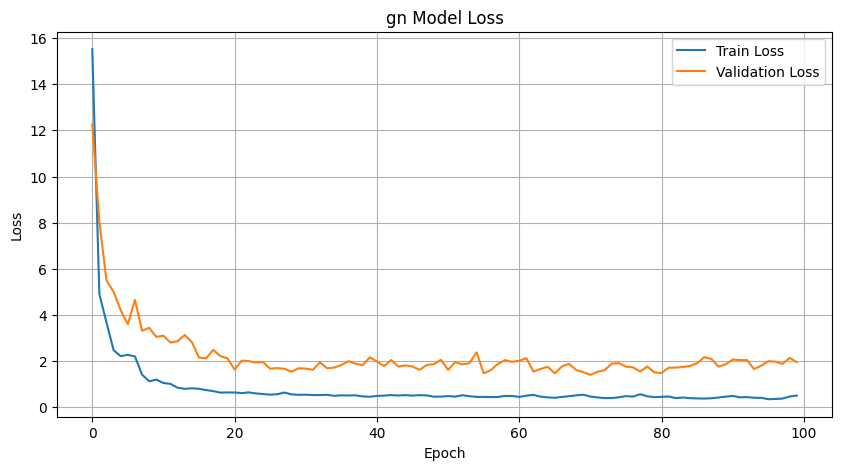

In [82]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_ts_gn.history['loss'], label='Train Loss')
plt.plot(history_ts_gn.history['val_loss'], label='Validation Loss')
plt.title('gn Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

val loss in ts_gn model: 0.922390878200531

val accuracy in ts_gn model: 0.5588235259056091

compared with original

val loss in ts model: 2.050161123275757

val accuracy in ts model: 0.6016042828559875

the loss decresed significently and accuracy decreased slightly


## 2.3 cBetaVAE

In [137]:
seq_len = 8
feat_dim = 64
batch_size = 128
latent_dim = 64
output_dim = 2

In [138]:
X_train_ts_vae = X_train.reshape(-1, seq_len, feat_dim) 

In [147]:
model_type = tsgm.models.architectures.zoo["cvae_conv5"]
architecture = model_type(seq_len=seq_len, feat_dim=feat_dim, latent_dim=latent_dim, output_dim=2)

# why the dimention 1 of decoder become 9? 
encoder, decoder = architecture.encoder, architecture.decoder

cbk = tsgm.models.monitors.VAEMonitor(num_samples=1, latent_dim=latent_dim, output_dim=2)

vae = tsgm.models.cvae.cBetaVAE(encoder, decoder, latent_dim=latent_dim, temporal=False)
vae.compile(optimizer=keras.optimizers.legacy.Adam(0.0003))



KeyboardInterrupt: 

In [142]:
print(X_train_ts_scaled_32.shape)
print(y_train_onehot_32.shape)
print(X_train_ts_vae.shape)
y_train_onehot_expanded = tf.expand_dims(y_train_onehot_32, axis=1)
print(y_train_onehot_expanded.shape)

(1496, 8, 64)
(1496, 2)
(1496, 8, 64)
(1496, 1, 2)


In [145]:
vae.fit(X_train_ts_vae, y_train_onehot_32, epochs=1, batch_size=128, callbacks=[cbk])
x_decoded = vae.predict([X, y])

ValueError: in user code:

    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/andrew/PycharmProjects/BayesianWF/env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/andrew/PycharmProjects/tsgm_fork/tsgm/tsgm/models/cvae.py", line 204, in train_step
        encoder_input = self._get_encoder_input(X, labels)
    File "/Users/andrew/PycharmProjects/tsgm_fork/tsgm/tsgm/models/cvae.py", line 182, in _get_encoder_input
        return tf.concat([X, rep_labels], axis=2)

    ValueError: Dimension 1 in both shapes must be equal, but are 8 and 9. Shapes are [?,8] and [?,9]. for '{{node concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](IteratorGetNext, Repeat/Reshape_1, concat/axis)' with input shapes: [?,8,64], [?,9,2], [] and with computed input tensors: input[2] = <2>.


In [115]:
# test cvae code

seq_len = 32
feat_dim = 1
output_dim = 2
latent_dim = 4

model_type = tsgm.models.architectures.zoo["cvae_conv5"]
architecture = model_type(seq_len=seq_len, feat_dim=feat_dim, latent_dim=latent_dim, output_dim=2)

encoder, decoder = architecture.encoder, architecture.decoder

X, y_i = tsgm.utils.gen_sine_vs_const_dataset(50, seq_len, feat_dim, max_value=20, const=10)

scaler = tsgm.utils.TSFeatureWiseScaler((0, 1))
X = scaler.fit_transform(X).astype(np.float64)
y = keras.utils.to_categorical(y_i, output_dim).astype(np.float64)

cbk = tsgm.models.monitors.VAEMonitor(
    num_samples=1, latent_dim=latent_dim, output_dim=2)

vae = tsgm.models.cvae.cBetaVAE(encoder, decoder, latent_dim=latent_dim, temporal=False)
vae.compile(optimizer=keras.optimizers.legacy.Adam(0.0003))


In [116]:
print(X.shape)
print(y.shape)

(50, 32, 1)
(50, 2)


In [117]:
vae.fit(X, y, epochs=1, batch_size=128, callbacks=[cbk])

1/1 [==============================] - 1s 877ms/step - loss: 104.7953 - reconstruction_loss: 104.7492 - kl_loss: 0.0461
